# Testing bootstrapped ensemble test-set filter on preproject feature-set

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_lr_filter as BE_LR_filter
import helper


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from time import time
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array

import pprint
import pickle

figure_path = module_path + '/figures/'

# Load data, and select features

In [2]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TEST.ts')


In [3]:
from sklearn.model_selection import train_test_split

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))

X_train.head(10)


y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Testing double classifier approach with filtering based on Logistic Regression

### Hyperparameter search for double classifier

The hyperparameters are number of **folds = f** which the training dataset will be devided into, in order to make **f** ensemble classifiers. The other hyperparameter is **threshold**, which is the number of ensembles that classify an example as probably incorrect, before the sample will be removed from the testing set.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

k_range = list(range(1,8))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

thresh_list = [2,4,6]
folds_list = [5, 7, 10]


param_dict = BE_LR_filter.hyperparam_search(X_train,y_train, X_val, y_val, clf_dict, grid_dict = grid_dict, thresh_list = thresh_list, folds_list = folds_list)

pprint.pprint(param_dict)
pprint.pprint(clf_dict)

{}


## Testing with the optimal hyperparameters

In [4]:
param_dict = {'knnOptimal': {'folds': 10, 'threshold': 2},
 'nb': {'folds': 10, 'threshold': 2}}
clf_dict = {'knnOptimal': KNeighborsClassifier(n_neighbors=4, weights='distance'),
 'nb': GaussianNB()}

In [5]:
_, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, X_test, y_test, clf_dict, param_dict = param_dict)

auc_init, auc_filtered , _= helper.get_auc_scores(X_test, y_test, clf_dict, indices)
print('AUC score for the initial classifiers: ')
pprint.pprint(auc_init)
print('AUC score for the filtered dataset: ')
pprint.pprint(auc_filtered)

AUC score for the initial classifiers: 
{'knnOptimal': 0.7507842327559352, 'nb': 0.6093180616229452}
AUC score for the filtered dataset: 
{'knnOptimal': 0.7335972396822426, 'nb': 0.6227272727272728}


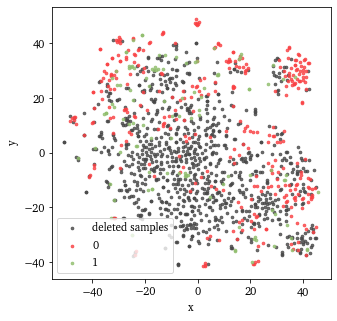

In [9]:
dim_red = 'tsne'
X_test_2d = helper.get_dim_reduced_X(X_test, dim_red, X_train, y_train)
mask=np.full(len(y_test),True,dtype=bool)
mask[indices['knnOptimal']]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = helper.scatterplot_with_colors(X_test_2d, new_y_test.values)
f.savefig(figure_path + f'lung_sound_data_lr_filtered_{dim_red}.pdf', bbox_inches='tight')

In [15]:
ampl_list = [5, 10, 15, 20, 25, 30, 35, 40]
filtered = {}
init = {}
removed_data = {}

for ampl in ampl_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, ampl, 4)
    
    dict_results, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)
    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[ampl] = auc_filtered
    init[ampl] = auc_init
    removed_data[ampl] = rm_data
    
pprint.pprint(filtered, depth = 3)
pprint.pprint(init, depth = 3)
pprint.pprint(removed_data, depth = 3)

a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_lr_amplitude.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

{5: {'knnOptimal': 0.6713486084955013, 'nb': 0.5714285714285714},
 10: {'knnOptimal': 0.6713486084955013, 'nb': 0.5707013574660633},
 15: {'knnOptimal': 0.6713486084955013, 'nb': 0.5669134786781845},
 20: {'knnOptimal': 0.6713486084955013, 'nb': 0.5669134786781845},
 25: {'knnOptimal': 0.6713486084955013, 'nb': 0.5638353996307044},
 30: {'knnOptimal': 0.6713486084955013, 'nb': 0.5640756302521008},
 35: {'knnOptimal': 0.6713486084955013, 'nb': 0.5640756302521008},
 40: {'knnOptimal': 0.6713486084955013, 'nb': 0.5640756302521008}}
{5: {'knnOptimal': 0.687549354139952, 'nb': 0.58024530365927},
 10: {'knnOptimal': 0.6860714466830395, 'nb': 0.58024530365927},
 15: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 20: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 25: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 30: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 35: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 40: {'knnOp

In [16]:
amount_list = [12, 10, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
filtered = {}
init = {}
removed_data = {}

for am in amount_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, 15, am)
    
    dict_results, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[am] = auc_filtered
    init[am] = auc_init
    removed_data[am] = rm_data

    
pprint.pprint(filtered, depth = 3)
pprint.pprint(init, depth = 3)
pprint.pprint(removed_data, depth = 3)

a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_lr_amount.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

{2: {'knnOptimal': 0.5932476763258612, 'nb': 0.5434842062081225},
 3: {'knnOptimal': 0.6467558810357998, 'nb': 0.5675567423230975},
 4: {'knnOptimal': 0.6713486084955013, 'nb': 0.5669134786781845},
 5: {'knnOptimal': 0.6770963704630788, 'nb': 0.5824371598859808},
 7: {'knnOptimal': 0.6914301474275398, 'nb': 0.5926916221033868},
 10: {'knnOptimal': 0.6961269729566704, 'nb': 0.6044181483023131},
 12: {'knnOptimal': 0.7005813953488372, 'nb': 0.6147186147186148}}
{2: {'knnOptimal': 0.6186781421833909, 'nb': 0.5696210326516123},
 3: {'knnOptimal': 0.6690465323509596, 'nb': 0.5773909137669978},
 4: {'knnOptimal': 0.6860026225612716, 'nb': 0.58024530365927},
 5: {'knnOptimal': 0.7024769439192078, 'nb': 0.5845413777864714},
 7: {'knnOptimal': 0.7200850521252165, 'nb': 0.6005701535140148},
 10: {'knnOptimal': 0.7264929400940355, 'nb': 0.6023233574579993},
 12: {'knnOptimal': 0.7327631798193186, 'nb': 0.6054675331261365}}
{2: {'knnOptimal': 0.3101449275362319, 'nb': 0.20072463768115942},
 3: {'k